In [160]:
import pandas
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import os
%matplotlib inline

In [161]:
threshold_epsilon = 0.05
margin = 0.1
time_unit = 1000000000
duration = 6
quantile_trim = [0.05, 0.95]
buckets = 10

In [162]:
def wrangle_data(filename):
    result, data = read_data(filename)
    result, data = standardize_data(result, data)
    return trim_data(result, data)

In [163]:
def read_data(filename):
    keys = ['Age', 'Height', 'Weight', 'Gender']
    with open(filename) as f:
        ## collect data from file
        result = {}
        for i in range(8):
            next(f)
        for i in keys:
            tmp = f.readline()
            result[i] = tmp[(tmp.index(' ') + 1):-1]
        for i in range(4):
            next(f)
        data = []
        for r in f:
            d = r[:-1].split(', ')
            data.append([float(i) for i in d])
    return result, data

In [164]:
def standardize_data(result, data):
    x_med = np.median([d[1] for d in data])
    y_med = np.median([d[2] for d in data])
    z_med = np.median([d[3] for d in data])     
    result['duration'] = (data[-1][0] - data[0][0]) / time_unit
    ## standardizes Y data by median and X time to 0 second start
    data = list(map(lambda d : 
                    [(d[0] - data[0][0]) / time_unit, 
                     d[1] - x_med, 
                     d[2] - y_med, 
                     d[3] - z_med], 
                    data))
    return result, data

In [165]:
def trim_data(result, data):
    x_data = [d[1] for d in data]
    x_min = min(x_data)
    x_max = max(x_data)  

    y_data = [d[2] for d in data]
    y_min = min(y_data)
    y_max = max(y_data)

    z_data = [d[3] for d in data]
    z_min = min(z_data)
    z_max = max(z_data)

    del x_data
    del y_data
    del z_data

    ## cuts off start and end
    data = trim_quantiles(data, quantile_trim)

    ## find threshold amount to trim
    threshold = min([abs(x_max - x_min), abs(y_max - y_min), abs(z_max - z_min)]) * threshold_epsilon
    (l_trim, r_trim) = trim_threshold(data, threshold)
    l_trim = int(max([l_trim - len(data) * margin, 0]))
    r_trim = int(min([r_trim + len(data) * margin, len(data)]))
    result['data'] = data[l_trim:r_trim]
    return result, (l_trim, r_trim)

In [166]:
def trim_quantiles(data, quantiles):
    return data[int(len(data) * quantiles[0]):int(len(data) * quantiles[1])]

In [167]:
def trim_threshold(data, threshold):
    print(threshold)
    l_trim = 0
    while l_trim < len(data) - 2:
        # dt = data[l_trim][0] - data[l_trim + 1][0]
        dt = 1
        dx = data[l_trim][1] - data[l_trim + 1][1]
        dy = data[l_trim][2] - data[l_trim + 1][2]
        dz = data[l_trim][3] - data[l_trim + 1][3]
        if (abs(dx/dt) > threshold
        and abs(dy/dt) > threshold
        and abs(dz/dt) > threshold):
            print(dx/dt, dy/dt, dz/dt)
            break
        else:
            l_trim += 1
            
    r_trim = len(data) - 1
    while r_trim > l_trim:
        # dt = data[r_trim][0] - data[r_trim - 1][0]
        dt = 1
        dx = data[r_trim][1] - data[r_trim - 1][1]
        dy = data[r_trim][2] - data[r_trim - 1][2]
        dz = data[r_trim][3] - data[r_trim - 1][3]
        if (abs(dx/dt) > threshold
        and abs(dy/dt) > threshold
        and abs(dz/dt) > threshold):
            print(dx/dt, dy/dt, dz/dt)
            break
        else:
            r_trim -= 1
            
    return (l_trim, r_trim)

In [168]:
def plot_data(data, title=None):
    n = len(data)
    Xs = [data[i][0] for i in range(n)]
    Ys = [data[i][1] for i in range(n)]
    plt.title(title)
    plt.plot(Xs, Ys, c="r")
    Ys = [data[i][2] for i in range(n)]
    plt.plot(Xs, Ys, c="g")
    Ys = [data[i][3] for i in range(n)]
    plt.plot(Xs, Ys, c="b")
    plt.show()

In [169]:
## edward wrote this, michael wrote everything else
def get_files(root_dir):
    result = [root_dir + file for file in os.listdir(root_dir) if not os.path.isdir(root_dir+file)]
    for file in [file for file in os.listdir(root_dir) if os.path.isdir(root_dir+file)]:
        result = result + get_files(root_dir + file + '/')
    return result

In [170]:
def load(root='./MobiFall/', plot=False):
    root_dir = root
    categories = {}
    for file in [file for file in get_files(root_dir) if file[-4:] == '.txt' and file[-6] == '_' 
                 and ('acc' in file)]:
        prefix = os.path.basename(file)[0:3]
        if prefix not in categories:
            obj = []
            categories[prefix] = obj
        result, domain = wrangle_data(file)
        categories[prefix].append(result)
        if plot:
            plot_data(result['data'], file)
    return categories

1.174116485
1.2258313 -3.62961 -3.6679174
1.570596 1.1875241 -1.302445


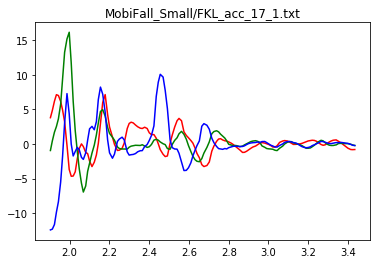

0.984495725
-2.8826188 -1.2449847 1.005565
-1.340753 3.0454247 1.742979


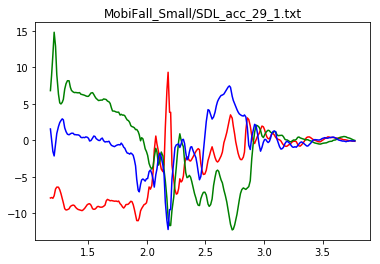

0.991678315
-1.22583127 1.2641384 1.4365211
3.0071177 -1.0534487 1.3216


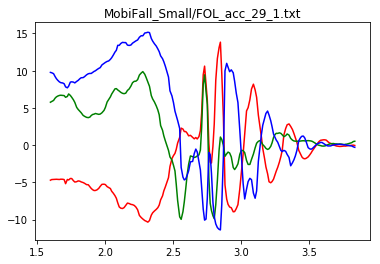

1.2679692
1.4748282 1.4365213 1.3790601
-2.231396 -1.4173675 -2.0781668


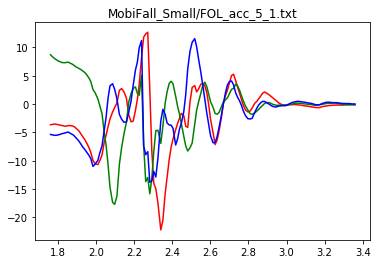

1.13868235
1.292869 2.80600449 -2.4995465
1.9823996 2.470816 2.6144677


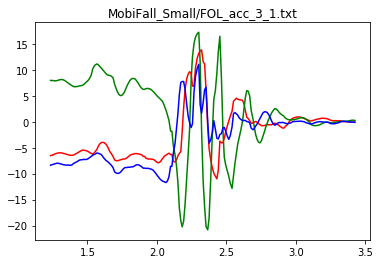

0.331357515


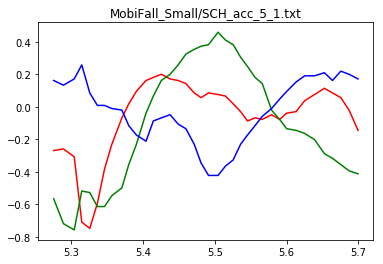

0.78529815
2.5282769 0.957681 -0.9768343
-1.5801728 -1.091756 1.158794


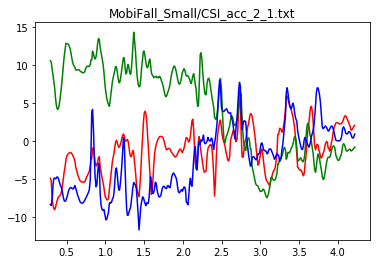

0.1637634
-0.17238254 0.42138 0.2011129
-0.2394202 0.402225 0.392649


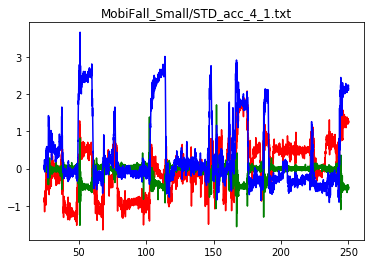

1.05392755
-3.955222 6.1961936 -6.3302685
2.2697036 -1.52271227 1.331176


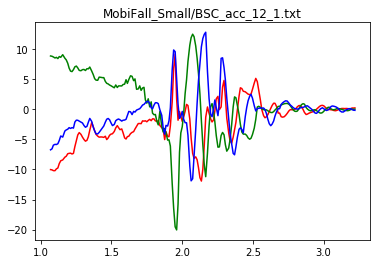

1.215775635
2.2313958 1.254561 -1.50355872
-2.470817 -1.3790603 1.84832367


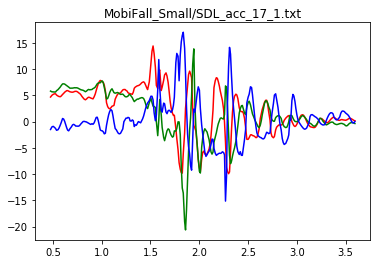

0.592804305
1.4652515 1.3790604 -1.0055647
-1.6376338 0.9481037 1.1779471


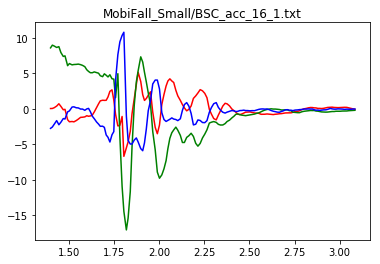

In [ ]:
categories = load('MobiFall_Small/', True)

In [ ]:
# lst = []
# for cat in categories.keys():
#     for c in categories[cat]:
#         lst.append(c['duration'])
        
# ## most points lie in ~6 billion as the duration
# plt.hist(lst)